FAKE_TORINO: P(final) = {'0': 0.652608, '1': 0.34739200000000003}


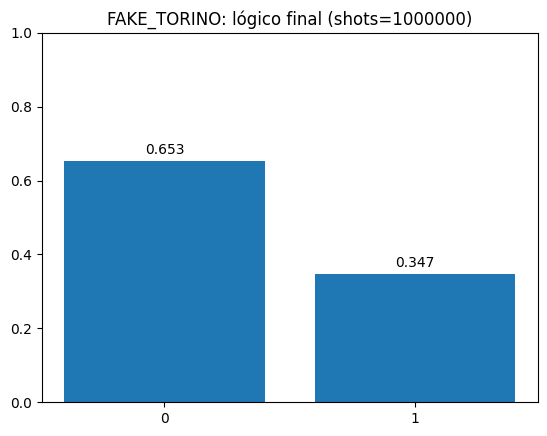

FAKE_TORINO: P(síndromes) = {'(s0,s1)=0,0': 0.949601, '(s0,s1)=0,1': 0.022558, '(s0,s1)=1,0': 0.016059, '(s0,s1)=1,1': 0.011782}


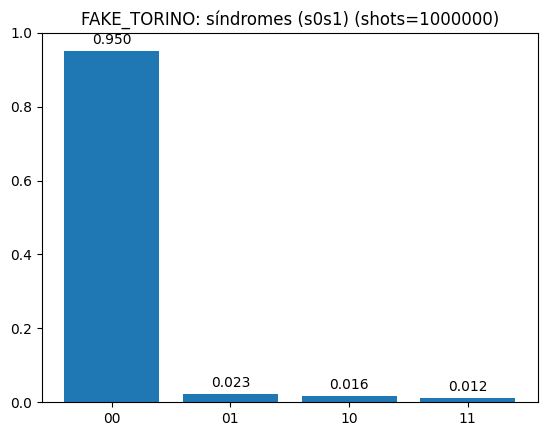

Tiempo total: 23.28s


In [3]:
# -*- coding: utf-8 -*-
# Requisitos:
#   pip install "qiskit>=2.1" "qiskit-aer>=0.14" "qiskit-ibm-runtime" matplotlib

import os, math, time
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.primitives import BackendSamplerV2
from qiskit_ibm_runtime.fake_provider import FakeTorino  # <<--- NUEVO

# ========= Parámetros =========
USE_NOISE   = True
P1          = 3e-4
P2          = 3e-3
PM          = 1e-2
SHOTS       = 1_000_000
SEED_SIM    = 1234
THETA       = 2*np.arccos(np.sqrt(2/3))
ERROR_POS   = None            # None, 0, 1, 2
GRAFICAR    = "FAKE_TORINO"   # "SIN_RUIDO" | "CON_RUIDO" | "FAKE_TORINO"  <<--- NUEVO

# ========= Ruido (custom, solo si CON_RUIDO) =========
def build_noise_model(p1: float, p2: float, pm: float) -> NoiseModel:
    noise = NoiseModel()
    noise.add_all_qubit_quantum_error(depolarizing_error(p1, 1),
        ['x','y','z','h','s','sdg','t','tdg','rx','ry','rz','sx'])
    noise.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])
    ro = ReadoutError([[1-pm, pm],[pm,1-pm]])
    noise.add_all_qubit_readout_error(ro)
    return noise

# ========= Construcción del circuito =========
def encode_repetition3(qc: QuantumCircuit, d):
    qc.cx(d[0], d[1])
    qc.cx(d[0], d[2])

def extract_syndrome(qc: QuantumCircuit, d, a):
    qc.cx(d[0], a[0]); qc.cx(d[1], a[0])  # s0 = Z0Z1
    qc.cx(d[1], a[1]); qc.cx(d[2], a[1])  # s1 = Z1Z2

def decode_repetition3(qc: QuantumCircuit, d):
    qc.cx(d[0], d[2])
    qc.cx(d[0], d[1])

def build_stabilizer_bitflip(theta=THETA, error_pos=ERROR_POS) -> QuantumCircuit:
    d   = QuantumRegister(3, 'd')
    a   = QuantumRegister(2, 'a')
    c_s0 = ClassicalRegister(1, 's0')
    c_s1 = ClassicalRegister(1, 's1')
    c_fin= ClassicalRegister(1, 'final')
    qc  = QuantumCircuit(d, a, c_s0, c_s1, c_fin, name='bitflip_stabilizer')

    qc.ry(theta, d[0]); qc.barrier()
    encode_repetition3(qc, d); qc.barrier(label="encode")

    if error_pos in (0,1,2):
        qc.x(d[error_pos])
    qc.barrier(label="error")

    extract_syndrome(qc, d, a)
    qc.measure(a[0], c_s0[0])
    qc.measure(a[1], c_s1[0])
    qc.barrier(label="measure_syndrome")

    # (s0,s1): (1,0)->X d0 ; (1,1)->X d1 ; (0,1)->X d2
    with qc.if_test((c_s0[0], 1)):
        with qc.if_test((c_s1[0], 0)):
            qc.x(d[0])
        with qc.if_test((c_s1[0], 1)):
            qc.x(d[1])
    with qc.if_test((c_s0[0], 0)):
        with qc.if_test((c_s1[0], 1)):
            qc.x(d[2])
    qc.barrier(label="correct")

    decode_repetition3(qc, d); qc.barrier(label="decode")
    qc.measure(d[0], c_fin[0])
    return qc

# ========= Sampler y utilidades =========
def run_sampler(circ: QuantumCircuit, backend, shots: int) -> Counter:
    sampler = BackendSamplerV2(backend=backend)
    res = sampler.run([circ], shots=shots).result()[0]
    return Counter(res.join_data().get_counts())

def marginalize_bit(circ: QuantumCircuit, counts: Counter, clbit) -> dict:
    idx = circ.clbits.index(clbit)
    tot = sum(counts.values())
    p0  = sum(c for k,c in counts.items() if isinstance(k,str) and k[-1-idx] == '0')
    return {'0': p0/tot, '1': 1 - p0/tot}

def marginalize_pair(circ: QuantumCircuit, counts: Counter, clbit0, clbit1) -> dict:
    i0 = circ.clbits.index(clbit0); i1 = circ.clbits.index(clbit1)
    tot = sum(counts.values()); acc = {'00':0,'01':0,'10':0,'11':0}
    for k,c in counts.items():
        if not isinstance(k,str): continue
        acc[k[-1-i0] + k[-1-i1]] += c
    for k in acc: acc[k] /= tot
    return acc

def plot_bar(probs: dict, title: str):
    plt.bar(probs.keys(), probs.values()); plt.ylim(0, 1)
    for x,v in probs.items(): plt.text(x, min(1.0, v+0.02), f"{v:.3f}", ha='center')
    plt.title(title); plt.show()

# ========= Main =========
def main(graficar: str):
    qc = build_stabilizer_bitflip(theta=THETA, error_pos=ERROR_POS)
    n_threads = max(1, math.floor(os.cpu_count() / 3))

    if graficar == "SIN_RUIDO":
        backend = AerSimulator(method="statevector", seed_simulator=SEED_SIM)
        backend.set_options(max_parallel_threads=n_threads,
                            max_parallel_experiments=n_threads,
                            fusion_enable=True, blocking_enable=True)
        qc_t = transpile(qc, backend, optimization_level=3, seed_transpiler=SEED_SIM)
        counts = run_sampler(qc_t, backend, SHOTS)

    elif graficar == "CON_RUIDO":
        noise = build_noise_model(P1, P2, PM)
        backend = AerSimulator(method="density_matrix", noise_model=noise, seed_simulator=SEED_SIM)
        backend.set_options(max_parallel_threads=n_threads,
                            max_parallel_experiments=n_threads,
                            fusion_enable=True, blocking_enable=True)
        qc_t = transpile(qc, backend, optimization_level=3, seed_transpiler=SEED_SIM)
        counts = run_sampler(qc_t, backend, SHOTS)

    elif graficar == "FAKE_TORINO":  # <<--- NUEVO: backend realista
        fake = FakeTorino()
        # Construye un AerSimulator con acoplamientos/basis/noise derivados del backend real
        backend = AerSimulator.from_backend(fake, seed_simulator=SEED_SIM)
        backend.set_options(max_parallel_threads=n_threads,
                            max_parallel_experiments=n_threads,
                            fusion_enable=True, blocking_enable=True)
        # Transpila al mapa de acoplamientos y base de puertas de Torino
        qc_t = transpile(qc, backend, optimization_level=3, seed_transpiler=SEED_SIM)
        counts = run_sampler(qc_t, backend, SHOTS)

    else:
        raise ValueError("graficar debe ser 'SIN_RUIDO', 'CON_RUIDO' o 'FAKE_TORINO'.")

    # Resultados
    probs_final = marginalize_bit(qc_t, counts, qc_t.cregs[-1][0])  # 'final'[0]
    print(f"{graficar}: P(final) = {probs_final}")
    plot_bar(probs_final, f"{graficar}: lógico final (shots={SHOTS})")

    # Síndromes (s0, s1)
    s0_bit = qc_t.cregs[0][0]
    s1_bit = qc_t.cregs[1][0]
    syn_probs = marginalize_pair(qc_t, counts, s0_bit, s1_bit)
    syn_named = {f"(s0,s1)={k[0]},{k[1]}": v for k, v in syn_probs.items()}
    print(f"{graficar}: P(síndromes) = {syn_named}")
    plot_bar(syn_probs, f"{graficar}: síndromes (s0s1) (shots={SHOTS})")

if __name__ == "__main__":
    t0 = time.time()
    main(GRAFICAR)
    print(f"Tiempo total: {time.time() - t0:.2f}s")
